# Utility Functions

In [23]:
# type annotations
from typing import List, Set, Tuple
from datetime import datetime, date
import pandas as pd
import numpy as np
import functools as ft
from praw import Reddit
from psaw import PushshiftAPI
import spacy
from spacy.lang.en import English
from spacy.tokens import DocBin
nlp = spacy.load("en_core_web_sm")

In [14]:
def word_per_year(df: pd.DataFrame, words: List[str], user_counts: List[int]) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda year: df.loc[df.year == year, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    wc_norm: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
    return pd.DataFrame({"years": years, "word_counts": word_counts, "wc_norm": wc_norm})


def append_wc(df: pd.DataFrame, words: List[List[str]], user_counts: List[int]) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, user_counts)), words, pd.DataFrame())
    nyear = df.year.unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df


def user_ents(u: str):
    """Get all entities associated with a given user."""
    grouped_ents = ents_df.loc[ents_df["username"] == u, :]["ents"].tolist()
    return ft.reduce(lambda x, y: x + y, grouped_ents, [])


def ents_by_type(ents, etype):
    """Get the text for entities of the given type from the given ents."""
    etypes = [e.text.lower().strip(".") for e in ents if e.label_ == etype]
    return etypes


def row_with_kw(df: pd.DataFrame, kw: str):
    """Returns row indexes of dataframe with ents with the given keyword."""
    return [i for i, ents in enumerate(ents_df["ents"].tolist()) 
            if kw in [str(e).lower() for e in ents]]

def disk_to_spacy(fp: str) -> List[English]:
    """Read spacy documents from disk."""
    docbin = DocBin().from_bytes(open(fp, "rb").read())
    disk_docs = docbin.get_docs(nlp.vocab)
    disk_docsl = list(disk_docs)
    return disk_docsl

# Read in data

In [2]:
# general processing
import pymongo
from utils import utc_to_dt, COLL, PSAW, PRAW
from tqdm import tqdm
from collections import Counter

In [3]:
# read in full mongo collection
res = COLL.find({})
df = pd.DataFrame(res)

ServerSelectionTimeoutError: 10.99.248.17:27017: timed out

In [18]:
hist_df.shape

(458859, 5)

In [26]:
# read in top n posting histories
hist_df = pd.read_csv("data/histories.csv")

# User Histories

In [5]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

## User Plots

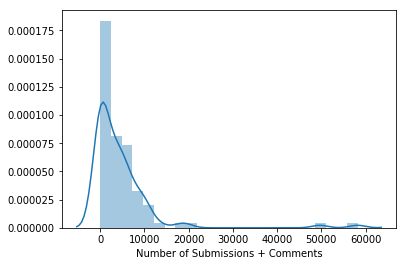

In [28]:
user_counts = hist_df.groupby("username").count().sort_values("id").reset_index()
ax = sns.distplot(user_counts["id"].tolist())
ax.set(xlabel="Number of Submissions + Comments")
plt.show()

## Convert history text to spacy

In [ ]:
# convert text to spacy docs
text_idx = [i for i, t in enumerate(hist_df["text"].tolist()) if type(t) == str]
text_docs = [t for t in hist_df["text"].tolist() if type(t) == str]
spacy_docs = []
for t in tqdm(text_docs):
    spacy_docs.append(nlp(t))

  9%|▉         | 40036/456277 [06:18<1:23:22, 83.20it/s] 

In [313]:
# add spacy docs to users dataframe
hist_df["spacy"] = spacy_docs

## Extract entities

In [30]:
ents_df = hist_df
ents_df["ents"] = ents_df["spacy"].apply(lambda sp: list(sp.ents) if len(sp.ents) > 0 else None)
ents_df = ents_df.dropna()

KeyError: 'spacy'

## Explore entities by user

In [326]:
flat_ents = ft.reduce(lambda x, y: x + y, ents_df["ents"].tolist(), [])

In [357]:
# get observations with ents that match a keyword
atlanta_idx = row_with_kw(ents_df, "atlanta")
atlanta_df = ents_df.iloc[atlanta_idx, :]

In [347]:
# get entities for a given user
u1_ents = user_ents("realcat67")
u1_gpe = ents_by_type(u1_ents, "GPE")

## Display entities with displaCy

In [ ]:
from spacy import displacy

In [303]:
# visualize entities
docs = ents_df["spacy"].tolist()[900:902]
vis_docs = [d for d in docs if len(d.ents) > 0]
for i, d in enumerate(vis_docs):
    print("Doc:", i)
    display(HTML(displacy.render(d, style='ent', page=True)))

Doc: 0


Doc: 1


In [46]:
users_df["gpes"] = users_df["spacy"].apply(lambda x: [e for e in x.ents if e.label_ == "GPE"])

In [78]:
gpes_by_user

,username,gpes
0,FashionablyFake,"[(Kilos), (soooo), (Dallas), (Whatevz), (bk), ..."
1,KickerS12X,"[(kiddo), (Vermont), (xanax), (north, troy), (..."
2,OlDirtyBurton,"[(APVP), (US), (Adderall), (US), (US), (Tina),..."
3,chasing-d0pamine,"[(Wharton), (Adderall), (america), (Adderall),..."
4,heroinking,"[(turkey), (turkey), (APVP), (APVP), (turkey),..."
5,spinderella69,"[(NY), (Molly), (kinda), (Kratom), (Kratom), (..."
6,street_philatelist,"[(Fentanyl, Warnings, State), (SN), (Florida),..."
7,traceyh415,"[(R.C.), (Chicago), (Phoenix), (AZ), (Seattle)..."


In [73]:
gpes_by_user = users_df.groupby("username").agg({"gpes": lambda x: ft.reduce(lambda acc, y: acc + y, x)}).reset_index()

In [83]:
Counter([e.text for e in gpes_by_user["gpes"][4]]).most_common()

[('APVP', 127),
 ('Adderall', 107),
 ('US', 54),
 ('Seroquel', 25),
 ('Xanax', 18),
 ('USA', 16),
 ('Discord', 11),
 ('Wisconsin', 9),
 ('APHP', 9),
 ('China', 8),
 ('America', 8),
 ('UK', 8),
 ('LE', 7),
 ('Canada', 7),
 ('California', 7),
 ('turkey', 6),
 ('Tylenol', 6),
 ('Florida', 6),
 ('Missouri', 6),
 ('Mexico', 5),
 ('Walmart', 5),
 ('Vendor', 5),
 ('Minneapolis', 4),
 ('MDPV', 4),
 ('M1', 4),
 ('Tina', 4),
 ('Ketamine', 4),
 ('Molly', 4),
 ('Oxycodone', 4),
 ('Miami', 3),
 ('Opana', 3),
 ('meth', 3),
 ('Valium', 3),
 ('Ambien', 3),
 ('Temazepam', 3),
 ('Pentylone', 3),
 ('Hydrocodone', 3),
 ('Codeine', 3),
 ('JJ', 3),
 ('PWD', 3),
 ('Minnesota', 3),
 ('Eminem', 3),
 ('pedophilia', 3),
 ('china', 2),
 ('LSD', 2),
 ('Oxy', 2),
 ('Russia', 2),
 ('Bitcoin', 2),
 ('India', 2),
 ('Ativan', 2),
 ('Klonopin', 2),
 ('Utah', 2),
 ('blotter', 2),
 ('Vicodin', 2),
 ('xanax', 2),
 ('tina', 2),
 ('incognito', 2),
 ('Houston', 2),
 ('Elvis', 2),
 ('Pornhub', 2),
 ('adderall', 2),
 ('Nevada',

In [72]:
gpes_by_user["gpes"][3]

Counter({(Wharton, 1): 1,
         (Adderall, 1): 1,
         (america, 1): 1,
         (Adderall, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (Seroquel, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (va va va, 1): 1,
         (kinda, 1): 1,
         (Adderall, 1): 1,
         (Suburbia, 1): 1,
         (Xanax, 1): 1,
         (US, 1): 1,
         (Ulta, 1): 1,
         (India, 1): 1,
         (New York, 1): 1,
         (New York, 1): 1,
         (Adderall, 1): 1,
         (Aexandria, 1): 1,
         (Mexico, 1): 1,
         (US, 1): 1,
         (RX, 1): 1,
         (Vitamultin, 1): 1,
         (turkey, 1): 1,
         (turkey, 1): 1,
         (Ulta, 1): 1,
         (Kanye, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (blockchain, 1): 1,
         (Adderall, 1): 1,
         (Canada, 1): 1,
         (APVP, 1): 1,
         (Scotland, 1): 1,
         (Scotland, 1): 1,
         (Tumblr, 1): 1,
         

# Word Usage

## Location Mentions

In [83]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(df, loc_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

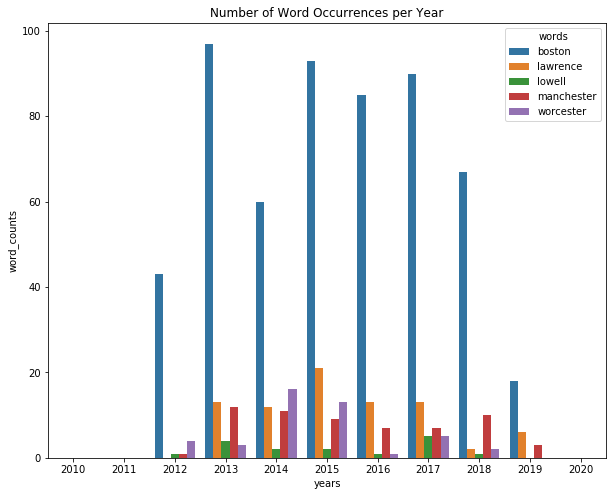

In [84]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Drug Mentions

In [85]:
drug_words = [["fentanyl", "fent", "fenty"], ["heroin"]]
drug_df = append_wc(full_df, drug_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

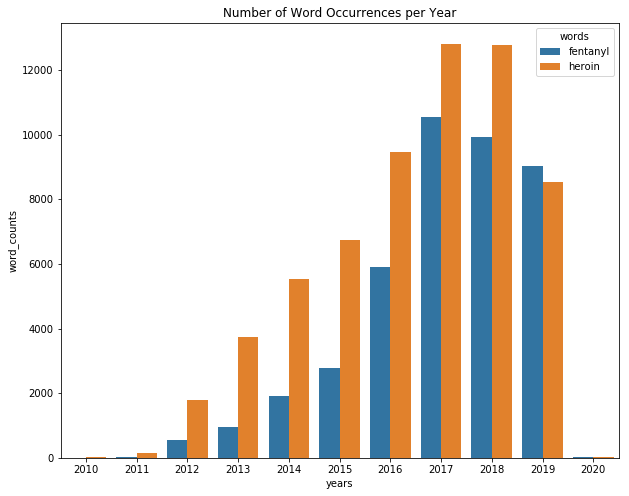

In [86]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=drug_df)
ax.set_title(f"Number of Word Occurrences per Year")

# Summative Visualizations

## Date Distributions

In [5]:
full_df["date"] = full_df.time.apply(lambda ts: date(ts.year, ts.month, ts.day))
date_groups = full_df.groupby("date").count().reset_index()

In [ ]:
df_19 = date_groups.loc[date_groups["date"] >= date(2019, 1, 1), :]
sns.barplot(x="date", y="hash", data=df_19)

## Number of Posts Over Time

### Count of Submissions Over Time

Text(0.5, 1.0, 'Number of r/opiates Submissions Over Time')

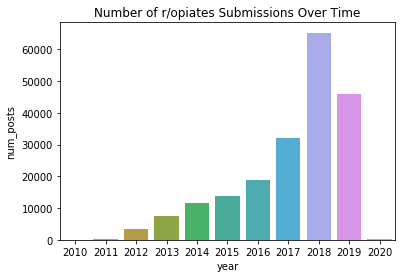

In [39]:
count_df = sub_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Submissions Over Time")

### Count of Submissions + Comments Over Time

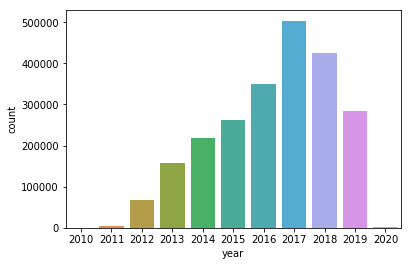

In [21]:
# group by year
query_str = { 
    "$group": { 
        "_id": { 
            "year": {"$year": "$time"}}, 
        "count": {
            "$sum": 1
        },
        "subs": {"$sum": 1}
    }
}
query = COLL.aggregate([query_str])

# extract data
query_li = list(query)
years = [str(it["_id"]["year"]) for it in query_li]
counts = [it["count"] for it in query_li]

# create dataframe
df = pd.DataFrame({"year": years, "count": counts})

# plot
sns.barplot(x="year", y="count", data=df)

### Count of Submissions + Real Comments

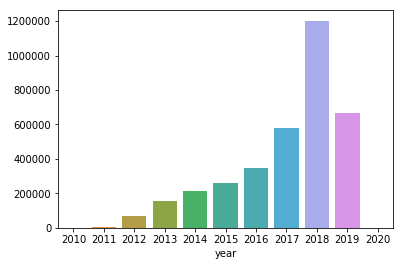

In [55]:
sub_df.query("year == '2017'").shape[0]
comms = sub_df.groupby("year")["num_comments"].sum().tolist()
subs = sub_df.groupby("year").count()
combined = [a + b for a, b in zip(comms, subs["hash"].tolist())]
sns.barplot(x=subs.index, y=combined)

### Real comments vs. extracted comments

In [44]:
real_comm_query = [
    {"$match": {
        "is_sub": True}},
    {"$group": {
        "_id": {"year": {"$year": "$time"}},
        "count": {"$sum": "$num_comments"}}}
]
real_res = COLL.aggregate(real_comm_query)
real_df = pd.DataFrame(list(real_res))
real_df["year"] = real_df["_id"].apply(lambda x: x["year"])

In [45]:
# group by year
raw_query = [
    {"$match": {"is_sub": False}},
    {"$group": {"_id": {"year": {"$year": "$time"}}, 
                "count": {"$sum": 1}}}
]
raw_res = COLL.aggregate(raw_query)
raw_df = pd.DataFrame(list(raw_res))
raw_df["year"] = raw_df["_id"].apply(lambda x: x["year"])

In [48]:
# combine dataframes
comm_df = real_df.merge(raw_df, on="year", how="inner")

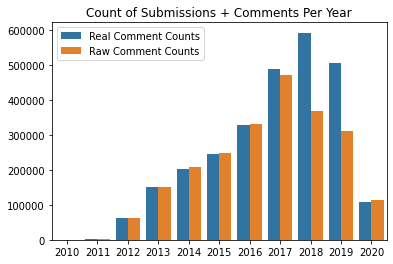

In [50]:
# plot
years = comm_df["year"].tolist() * 2
label = ["Real Comment Counts"] * comm_df.shape[0] + \
        ["Raw Comment Counts"] * comm_df.shape[0]
counts = comm_df["count_x"].tolist() + comm_df["count_y"].tolist()
ax = sns.barplot(x=years, y=counts, hue=label)
ax.set_title("Count of Submissions + Comments Per Year")
plt.show()

### Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

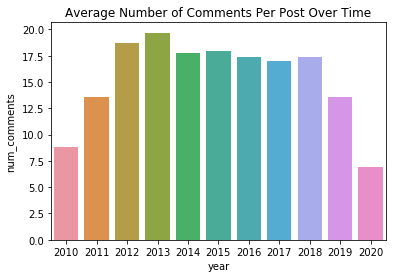

In [40]:
comm_df = sub_df.loc[:,["year", "num_comments"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

In [57]:
comm_counts = full_df.groupby("parent_id").count().reset_index()
comm_counts["new_par_id"] = comm_counts["parent_id"].apply(lambda x: x.replace("t1_", ""))

## Active Number of Users on R/Opiates Over Time

In [18]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

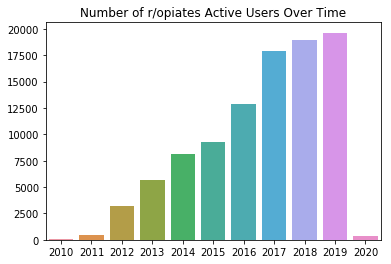

In [19]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Frequency Table

In [245]:
freq_df = pd.DataFrame(list(COLL.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [246]:
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [247]:
count_df

,Threads,Comments,Totals
year,,,
2019,175.0,2162.0,2337.0
